# パターン処理工学特論　最終レポート
学籍番号：35319051 　　　 氏名：柳原健吾


##1. 目的
　本講義では，PyTorchを用いた畳み込みニューラルネットワーク(CNN)モデルの構築，使用方法を学んできた．本レポートではオープンな

画像データセットであるCIFAR10を学習データセットとして使用するCNNモデルを構築し，本講義で学習した知識，技術の理解度を示す．

## 2. CIFAR10
　CIFAR10とはAlex Krizhevskyらによって作成されたインターネット上でオープンに公開されているラベル付きの画像データセットである．このデータセットは32×32のカラー画像6万枚で構成されており，そのうち5万枚がトレーニング画像，残りの1万枚がテスト画像として存在している．
それぞれの画像は"airplane"，"autmobile"，"bird"，"cat"，"deer"，"dog"，"frog"，"horse"，"ship"，"truck"の10個のうち1つにクラス分けされており，クラス間での画像の重複はない．[[1]](https://colab.research.google.com/drive/1x7-5E16sW9bnRiw8LshO5XX96JqT-WH3#scrollTo=TgnIiKp6vSwM)

　torchvisionライブラリはCIFAR10データセットが用意されており[[2]](https://colab.research.google.com/drive/1x7-5E16sW9bnRiw8LshO5XX96JqT-WH3#scrollTo=TgnIiKp6vSwM)，
本レポートではtorchvisionライブラリから，PyTorchが提供しているPyTorchのチュートリアル[[3]](https://colab.research.google.com/drive/1x7-5E16sW9bnRiw8LshO5XX96JqT-WH3#scrollTo=TgnIiKp6vSwM)
を参考にしてデータセットをダウンロードする．



In [1]:
#import libraryes
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
 
#device
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),transforms.RandomResizedCrop(size = [32,32],scale=(.7,1.3)),
                                transforms.RandomRotation(degrees = (-10,10)),transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
transform_test = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

#load CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(root = './data',train=True,download=True,transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root = './data',train=False,download=True,transform=transform_test)

datasets = {"train":train_dataset,"val":test_dataset}

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


　学習には並列演算性能の高いGPUを使うこととする．

　データセットを[-1,1]に正規化されたTensor型にtransformして学習用データセット
をtrain_datasetに，テスト用データセットをtest_datasetに格納した

　また，今回はモデルの汎用性向上や過学習の対策としてtorchvision.transformsを使学習用データセットに対してData Augmentation(データ拡張)を行っている．
Data Augmentation目的で使っているtransforms関数を以下の表に示す

transforms                                      |     意味
----------------------------------------------- |-------------
RandomHorizontalFlip(p=0.5)                     |     50%の確率で左右を反転する
RandomResizedCrop(size = [32,32],scale=(.7,1.3))|     (0.7~1.3)の倍率の範囲でランダムの箇所を拡大，縮小する
RandomRotation(degrees = (-10,10))              |    画像を(-10°~10°)の範囲の角度でランダムに回転する

transformによって現実には考えずらい画像(上下反転されている画像など)などが作成されて学習し，モデルの精度を逆に下げてしまわないように気を付けた．

 ## 3. CNNモデル
 
 　今回実装したCNNモデル(ConvNet)を以下に示す．

In [2]:
# define CNN model
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet,self).__init__()

    self.features = nn.Sequential(
        
        nn.Conv2d(3,32,5,1,2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        

        nn.Conv2d(32,64,5,1,2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(64,128,5,1,2),
        nn.BatchNorm2d(128),
        nn.ReLU(),


        nn.Conv2d(128,256,5,1,2),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(256,512,5,1,2),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.Conv2d(512,1024,5,1,2),
        nn.BatchNorm2d(1024),
        nn.ReLU(),
    )

    self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

    self.classifier = nn.Sequential(
           nn.Linear(1024,512),
            nn.ReLU(),       
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,10)
    )


  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x).squeeze(-1).squeeze(-1) # [B, C, H=1, W=1] -> [B, C]
    x = self.classifier(x)
    return x


MyModel = ConvNet().to(device)

summary(MyModel,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          51,264
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         204,928
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         819,456
      BatchNorm2d-12          [-1, 256, 16, 16]             512
             ReLU-13          [-1, 256, 16, 16]               0
        MaxPool2d-14            [-1, 25

今回作成したモデルは畳み込み層が6層，全結合層が4層で構成されており．活性化関数にLeRU関数を用意している．また，各畳み込み層のあとに学習速度向上のために**BatchNorm層**を追加している．
BatchNorm層とはBatchNormalization(バッチ正規化)を行う層であり，内部共変量シフトを解決するために各層の出力に対して正規化を行い，各層の入力の分布を統一することで学習の速度向上を図っている[[4]](https://colab.research.google.com/drive/1x7-5E16sW9bnRiw8LshO5XX96JqT-WH3#scrollTo=TgnIiKp6vSwM)

## ４.学習
　学習を安定させ，Dataloaderを使用してミニバッチ学習を行う．

　学習のハイパーパラメータを以下の表に示す．
　

hyper parameter |     val
--------------- |-------------
  num_epochs    |     50
  batch_size    |     100
  leaning_late  |    0.1, 0.01
  criterion     | CrossEntropyLoss()
  optimizer     | SGD

criterionは他クラス分類問題で主に使用されているCrossEntropyLossを採用し，optimizerにはSGD(確率的勾配降下法)を採用している．

学習は外れ値にある程度強くし，1データあたりの重要性を失わないようにするためミニバッチ学習を採用した． batch_sizeは小さくするほど精度が上がる（データの重要性が上がる）と考えられるが，小さくしすぎるとパラメータの更新が多くなり学習にかかる時間が増大してしまうため，バッチサイズを変えながら学習を何度かおこなってテストし，学習速度が許容できる100とした．

num_epochsは何度か学習を行い，損失が十分収束する回数を調べて設定した．

学習の最初は局所解に陥らないために学習率を大きく設定するのが望ましい．しかし学習が進んで損失が小さくなってくるとモデルを細かく調整するために学習率は小さいほうが良い．よって，leaning_late(学習率)は初期設定を0.1とし，torch.optim.lr_schedulerを使用してepochが40と60になったときにそれぞれ学習率を0.1倍し小さくするようにした．

In [3]:
#---hyper parameter---
num_epochs = 70
batch_size = 100
learning_late = 0.1
#---------------------

#-----------------------------------------DataLoader---------------------------------------
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle=True)

dataloaders = {"train":train_loader,"val":test_loader}

dataset_sizes = {x:len(datasets[x]) for x in {'train','val'}}

#--------------------------------------------------------------------------------------------

#Loss function
criterion = nn.CrossEntropyLoss()

# ----------------------------------optimizer,LR_Scheduler-----------------------------------
optimizer = torch.optim.SGD(MyModel.parameters(),lr = learning_late)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[40,60], gamma=0.1)
#-------------------------------------------------------------------------------------------------

TestModel,MyModelでそれぞれ学習した結果を以下に示す．

In [ ]:
#@title 学習関数
import copy
def train_model(model,criterion,optimizer,scheduler,num_epochs):
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  train_loss_history = []
  train_acc_history = []
  val_loss_history = []
  val_acc_history = []

  for epoch in range(num_epochs - 1):
    print('Epoch {}/{}'.format(epoch,num_epochs - 1))
    print('-' * 10)

    for phase in ['train','val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for inputs,labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _,pred = torch.max(outputs,1)
          loss = criterion(outputs,labels)

          if phase == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(pred == labels.data).item()

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc =float(running_corrects) / dataset_sizes[phase]


      if phase == 'train':
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)
      else:
        val_loss_history.append(epoch_loss)
        val_acc_history.append(epoch_acc)

      print('{} Loss: {:.4f} Acc: {:.4f} %'.format(
                  phase, epoch_loss, epoch_acc*100))


      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  print('Best val Acc: {:4f}'.format(best_acc))

  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax2 = fig.add_subplot(1,2,2)

  ax1.grid()
  ax1.plot(train_loss_history,label = "train_loss")
  ax1.plot(val_loss_history,label ="val_loss",color = "blue")
  ax1.legend()

  ax2.grid()
  ax2.plot(train_acc_history,label = "train_acc")
  ax2.plot(val_acc_history,label = "val_acc")
  ax2.legend()

  plt.show()

  # load best model weights
  model.load_state_dict(best_model_wts)

  return model

Epoch 0/69
----------
train Loss: 1.6293 Acc: 39.0840 %
val Loss: 1.3089 Acc: 51.5600 %

Epoch 1/69
----------
train Loss: 1.1843 Acc: 57.3640 %
val Loss: 1.3509 Acc: 55.3100 %

Epoch 2/69
----------
train Loss: 0.9745 Acc: 65.4240 %
val Loss: 0.9917 Acc: 66.4000 %

Epoch 3/69
----------
train Loss: 0.8402 Acc: 70.4120 %
val Loss: 0.8970 Acc: 69.0300 %

Epoch 4/69
----------
train Loss: 0.7519 Acc: 73.9660 %
val Loss: 0.8983 Acc: 70.4200 %

Epoch 5/69
----------
train Loss: 0.6869 Acc: 76.2140 %
val Loss: 0.7022 Acc: 76.0300 %

Epoch 6/69
----------
train Loss: 0.6361 Acc: 77.9300 %
val Loss: 0.6635 Acc: 77.5800 %

Epoch 7/69
----------
train Loss: 0.5918 Acc: 79.6320 %
val Loss: 0.6078 Acc: 79.6700 %

Epoch 8/69
----------
train Loss: 0.5527 Acc: 80.7800 %
val Loss: 0.6689 Acc: 78.3300 %

Epoch 9/69
----------
train Loss: 0.5198 Acc: 81.8860 %
val Loss: 0.6958 Acc: 77.5400 %

Epoch 10/69
----------
train Loss: 0.4987 Acc: 82.6020 %
val Loss: 0.5636 Acc: 81.2700 %

Epoch 11/69
--------

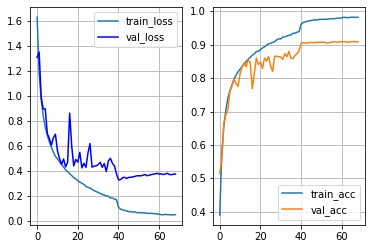

In [ ]:
MyModel = train_model(MyModel,criterion,optimizer,scheduler,num_epochs)

## 5.評価

　　上記のとおり，test用のデータセットの推論精度は約91%という結果になった．

　次に，クラス別の推論精度と，混合行列を以下に示す．

In [ ]:
#@title 学習したmodelを保存
BestMyModel = MyModel
modelname = "model_state.pkl"

from google.colab import drive
drive.mount('/content/drive')
model_path="/content/drive/MyDrive/"
torch.save(BestMyModel.to('cpu').state_dict(), model_path + modelname)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#@title modelを読み込む
modelname = "model_state.pkl"

from google.colab import drive
drive.mount('/content/drive')
model_path="/content/drive/MyDrive/"



LoadModel = ConvNet().to(device)
LoadModel.eval()
LoadModel.load_state_dict(torch.load(model_path+modelname))


#外部から確認
!git clone 

Mounted at /content/drive


<All keys matched successfully>

In [5]:
with torch.no_grad():
  y_true_array = np.array([])
  y_pred_array = np.array([])

  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]

  for images,labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = LoadModel(images)
    batch_size = images.size(0)

    _,predicted = torch.max(outputs,1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

    y_true_array = np.append(y_true_array,labels.to('cpu').detach().numpy().copy())
    y_pred_array = np.append(y_pred_array,predicted.to('cpu').detach().numpy().copy())

    for i in range(batch_size):
      label = labels[i]
      pred = predicted[i]
      if(label==pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

  for i in range(10):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 90.92 %
Accuracy of plane: 92.2 %
Accuracy of car: 96.2 %
Accuracy of bird: 87.2 %
Accuracy of cat: 82.3 %
Accuracy of deer: 90.3 %
Accuracy of dog: 83.0 %
Accuracy of frog: 94.9 %
Accuracy of horse: 94.4 %
Accuracy of ship: 94.0 %
Accuracy of truck: 94.7 %


In [6]:
from sklearn.utils.multiclass import type_of_target
print(metrics.confusion_matrix(y_true_array,y_pred_array))

[[922   4  18   9   6   1   2   3  21  14]
 [  5 962   1   2   0   1   1   1   9  18]
 [ 15   1 872  22  31  20  24  10   3   2]
 [  5   2  18 823  23  79  30   7   7   6]
 [  3   1  22  14 903  15  17  20   3   2]
 [  6   1  18  89  19 830  11  20   3   3]
 [  3   1  11  19   8   3 949   2   3   1]
 [  4   1   9  12   8  19   0 944   1   2]
 [ 28   7   3   2   3   1   0   0 940  16]
 [ 12  22   2   3   1   1   2   2   8 947]]


上記より，猫クラスと犬クラスの認識精度が低いことが分かる．また，混合行列より，認識精度が低かった犬クラスと猫クラスの画像がお互いのクラスに誤認識している画像が多いことが分かる．

　次に，このモデルが画像のどの箇所の特徴を捉えているかをgrad-cam[[5]](https://colab.research.google.com/drive/1x7-5E16sW9bnRiw8LshO5XX96JqT-WH3#scrollTo=TgnIiKp6vSgM)
 を使って確認する．

 今回は下記のサイトで公開されているgrad-camを行うことができるライブラリを使用する．

 https://github.com/jacobgil/pytorch-grad-cam


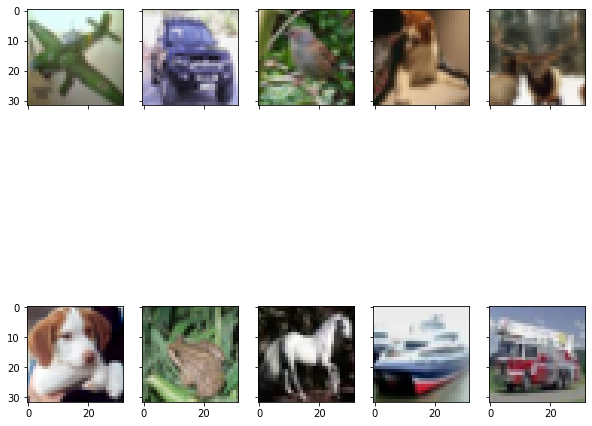

In [7]:
#@title 各クラスの画像を表示
#a = iter(test_dataset)
def get_img_data(index_array):
  out = []
  fig,axes = plt.subplots(2,5,figsize=(10,10),sharex = "all",sharey = "all")
  total = 0

  for index in index_array:
    Data,Label =test_dataset[index]
    data = Data
    data.unsqueeze_(0)

    label = Label

    img = data[0] / 2 + 0.5 
    # torch.Tensor->numpy.ndarray
    npimg = img.numpy()   
    # (RGB、ver、hor）->（ver、hor、RGB）
    npimg = np.transpose(npimg, (1, 2, 0))

    axes[int(total/5),int(total%5)].imshow(npimg)
    total = total+1

    o = {'data':data,'label':label,'npimg':npimg}
    out.append(o)

    
  plt.show()
  return out

index_array = [27,9,65,61,26,16,4,13,1,89]

Data = get_img_data(index_array)




In [25]:
#@title 上記の画像の推論結果を表示
for data in Data:
  with torch.no_grad():
    output = LoadModel(data['data'].to(device))

  _,out = torch.max(output,1) 
  print("class:[",classes[data['label']],"] 　result:",classes[out.cpu().numpy()[0]],"    ",bool(out==data['label']))


class:[ plane ] 　result: plane      True
class:[ car ] 　result: car      True
class:[ bird ] 　result: bird      True
class:[ cat ] 　result: dog      False
class:[ deer ] 　result: deer      True
class:[ dog ] 　result: dog      True
class:[ frog ] 　result: frog      True
class:[ horse ] 　result: horse      True
class:[ ship ] 　result: ship      True
class:[ truck ] 　result: truck      True


In [ ]:
!pip install grad-cam -q
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

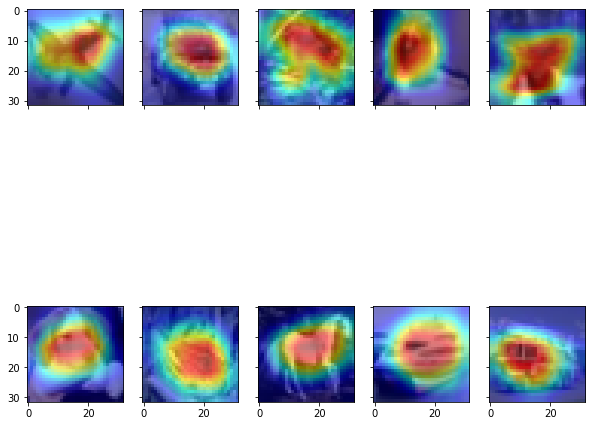

In [ ]:
#@title grad-cam
def gradcam(model,Data):
  target_layers = [model.features]
  cam = GradCAM(model = model, target_layers = target_layers, use_cuda = torch.cuda.is_available())

  fig,axes = plt.subplots(2,5,figsize=(10,10),sharex = "all",sharey = "all")
  total = 0

  for data in Data:
    grayscale_cam = cam(input_tensor = data['data'])
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(data['npimg'], grayscale_cam, use_rgb = True)

    axes[int(total/5),int(total%5)].imshow(visualization)
    total = total+1

  plt.show()

gradcam(LoadModel,Data)

上記の通り，どのクラスの画像も物体に関係がある特徴をとらえていることがわかる．よって今回作成したモデルは，CIFAR10の各画像の適切な特徴を使ってクラス分類を行っていることがわかった．また，toraansformも適切におこなわれ，Data Augmentationがモデルの汎用性向上に繋がってると考えている．

しかし，上記の画像の中で猫クラスの画像の推論結果が'犬'と誤認識されていた．これは猫と犬の顔や胴体が似ているからだと考える．よってさらなる精度の向上には猫と犬の細かい違いを識別することが必要であり，モデルの規模をさらに大きくすることやさらなるData Augmentationによってデータ水増しを行う必要があると考える．

## 6.Test scoring

In [26]:
!git clone https://github.com/modestyachts/CIFAR-10.1.git

Cloning into 'CIFAR-10.1'...
remote: Enumerating objects: 522, done.
remote: Total 522 (delta 0), reused 0 (delta 0), pack-reused 522
Receiving objects: 100% (522/522), 12.44 MiB | 22.67 MiB/s, done.
Resolving deltas: 100% (352/352), done.


In [27]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import numpy as np

class CIFAR101Dataset(Dataset):

    def __init__(self, transform=None):
        self.data = np.load("./CIFAR-10.1/datasets/cifar10.1_v6_data.npy")
        self.labels = np.load("./CIFAR-10.1/datasets/cifar10.1_v6_labels.npy")
        self.transform = transform

    def __getitem__(self, index):
        if self.transform is not None:
            return self.transform(self.data[index]), self.labels[index]
        return self.data[index], self.labels[index]

    def __len__(self):
        return self.data.shape[0]

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# !!! The same normalization as to the training dataset should be applied. !!!

batch_size = 100  # set as you like
cifar101dataset = CIFAR101Dataset(transform=test_transform)
cifar101loader = torch.utils.data.DataLoader(cifar101dataset, batch_size=batch_size, shuffle=False)

[0, 0, 0, 0, 9, 0, 0, 8, 8, 0, 0, 0, 9, 0, 3, 0, 0, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 6, 0, 0, 0, 0, 3, 1, 2, 0, 0, 0, 0, 0, 0, 8, 0, 0, 4, 0, 0, 7, 0, 4, 3, 0, 0, 0, 9, 0, 0, 8, 1, 0, 3, 8, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 8, 0, 2, 0, 0, 0, 0, 0, 0, 0, 7, 3, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 3, 8, 0, 0, 8, 0, 0, 7, 0, 7, 0, 2, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 9, 1, 9, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 9, 1, 1, 9, 1, 1, 1, 1, 1, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 1, 5, 1, 1, 3, 1, 1, 1, 1, 0, 3, 1, 1, 1, 9, 1, 1, 1, 3, 8, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

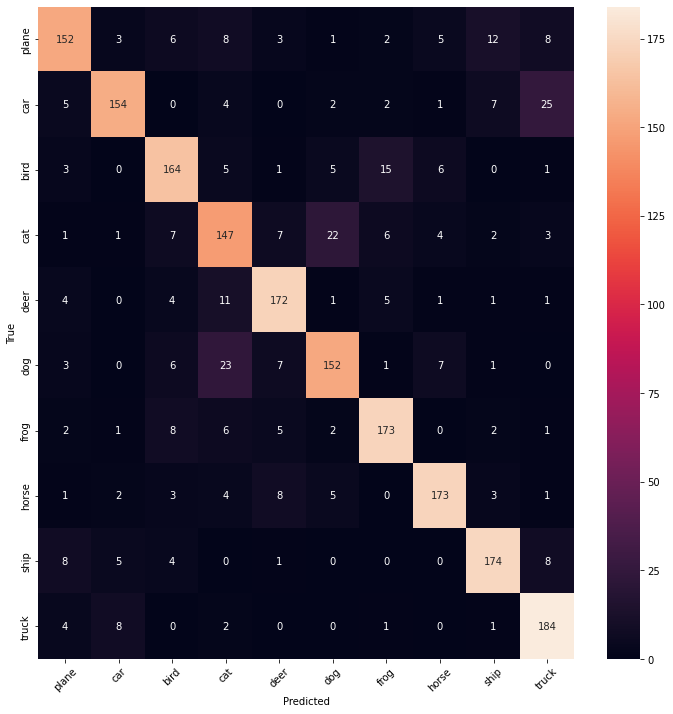

In [28]:
# [3]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# assumes there exists your `model` that has already been trained.
model = LoadModel
model.eval()

n_samples = 0
preds_all = []
labels_all = []
for inputs, labels in cifar101loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # track history if only in train
    with torch.set_grad_enabled(False):
        outputs = model(inputs)

    _, preds = torch.max(outputs, 1)
    preds_all += preds.tolist()
    labels_all += labels.tolist()
print(preds_all)
print(labels_all)


from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(labels_all, preds_all))
cm = confusion_matrix(labels_all, preds_all)
print(cm)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import pandas as pd
cm_df = pd.DataFrame(cm, classes, classes)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))

import seaborn as sns
sns.heatmap(cm_df, annot=True, fmt=".0f")

plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.ylabel('True')
plt.ioff()

テストのスコアは上記の通りになった．
テストでは

車クラスがトラッククラスに

猫クラスが犬クラスに

犬クラスが犬クラスに

誤認識されている画像が多い．この結果からも特徴が似ているクラス同士の誤認識が多いため，モデルのさらなる表現力向上が課題であることが分かった．

しかし，モデルの規模が大きくなると学習時間も多くかかってしまうため，高性能なGPUの導入など学習環境の改善も必要である．

## 参考文献
[1] Alex Krizhevsky "CIFAR-10 and CIFAR-100 datasets"

https://www.cs.toronto.edu/~kriz/cifar.html

[2] "Datasets — Torchvision main documentation - PyTorch"

https://pytorch.org/vision/stable/datasets.html


[3]"Training a Classifier — PyTorch Tutorials 1.12.0+cu102 ..."

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

[4] Ioffe, Sergey; Szegedy, Christian (2015). "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift".

https://arxiv.org/abs/1502.03167

[5] Ramprasaath R. Selvaraju, Michael Cogswell, Abhishek Das, Ramakrishna Vedantam, Devi Parikh, Dhruv Batra (2016). "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"

https://arxiv.org/abs/1610.02391